<a href="https://colab.research.google.com/github/ParthikB/Neural-Style-Transfer/blob/v0.0/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import keras.backend as K
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.preprocessing import image
from keras.models import Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt
# import cv2
import numpy as np

Using TensorFlow backend.


# Helper Functions

## 1) Creating Cost Functions

#### 1.1) Defining the dependencies

In [0]:
# # Generate Activation value/features at Layer block4_conv2
# def generateActivationValue(img, model):
#   imgArr = image.img_to_array(img)
#   imgArr = np.expand_dims(imgArr, axis=0)
#   imgArr = preprocess_input(imgArr)
#   activation = model.predict(imgArr)
#   return activation

In [0]:
# Defining the feature layers required
def getLayers():

  # Importing VGG19 Model
  model = VGG19(weights='imagenet', include_top=False)

  # Creating a Layer Dictionary --> layerName : layerOutput
  layers = dict([(layer.name, layer.output) for layer in model.layers])

  # Extracting the required activation output/features of Intermediate Layer of the Network
  contentLayer = layers['block4_conv2']

  styleLayer   = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
  styleLayer   = [layers[layer] for layer in styleLayer]

  return (contentLayer, styleLayer)

#### 1.2 Defining Cost Functions

In [0]:
# Content Cost Function
def computeContentCost(contentActivation, generatedActivation):
  return 0.5 * K.sum((contentActivation - generatedActivation)**2)

# Gram Matrix
def gramMatrix(x):
  return x * K.transpose(x)

# Style Cost
def computeStyleCost(styleActivation, generatedActivation):
  styleActivation     = gramMatrix(styleActivation)
  generatedActivation = gramMatrix(generatedActivation)
  return K.sum((styleActivation - generatedActivation)**2 / (2*224*224*3)**2)

# Total Cost
def totalCost(layers, ALPHA=10, BETA=40):
  
  # Extracting out the layers
  contentLayer, styleLayer = layers
  
  # Computing Content Cost
  contentActivation = contentLayer[0, :, :, :]
  generateActivation = contentLayer[1, :, :, :]

  contentCost = computeContentCost(contentActivation, generateActivation) 

  # Computing Style Cost
  styleCost = 0

  for layer in styleLayer: # Iterating over every layer and computing the features
    styleActivation    = layer[1, :, :, :]
    generateActivation = layer[2, :, :, :]

    styleCost += computeStyleCost(styleActivation, generateActivation)

  # Returning Total Cost with weights
  return ALPHA*contentCost + BETA*styleCost

## 2) Defining Images

In [0]:
def generateNoiseImage(contentImage, NOISE_RATIO = 0.97):
  img = np.random.uniform(-20, 20, (224, 224, 3)).astype('float32')
  noiseImg = (img * NOISE_RATIO) + (contentImage * (1-NOISE_RATIO))
  return noiseImg

In [0]:
def inputImageAndPreProcess(path):
  img = image.load_img(path, target_size=(224, 224, 3))
  img_arr = image.img_to_array(img)
  img_arr = np.expand_dims(img_arr, axis=0)
  img_arr = preprocess_input(img_arr)

  return img, img_arr

# Training

### Importing required Images

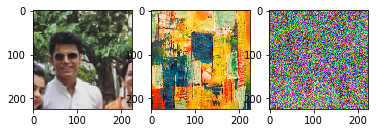

In [13]:
# Content Image
contentImage_path = "/content/drive/My Drive/Colab Notebooks/Neural Style Transfer/images/content1.jpg"
content, contentImage      = inputImageAndPreProcess(contentImage_path)

# Style Image
styleImage_path = "/content/drive/My Drive/Colab Notebooks/Neural Style Transfer/images/style1.jpg"
style, styleImage      = inputImageAndPreProcess(styleImage_path)

# Generate Image
generateImage = generateNoiseImage(image.img_to_array(content))
generateImage = image.array_to_img(generateImage)

f, axarr = plt.subplots(1,3)
axarr[0].imshow(content)
axarr[1].imshow(style)
axarr[2].imshow(generateImage)

### 

In [0]:
ITERATIONS = 1

layers = getLayers()

for epoch in range(ITERATIONS):

  totalCost = totalCost(layers) # Minimize this

In [0]:
import tensorflow as tf

with tf.Session() as sess:
  sess.run(totalCost)